##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Autoencoders

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. 

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [2]:
%config Completer.use_jedi = False

import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_transform as tft
import tensorflow_transform.beam.impl as tft_beam
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
import tensorflow_transform as tft
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
seed = 100
np.random.seed(seed)
tf.random.set_seed(seed)

## Load the dataset
To start, you will train the basic autoencoder using the Fashon MNIST dataset. Each image in this dataset is 28x28 pixels. 

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder
![Basic autoencoder results](images/intro_autoencoder_result.png)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [4]:
latent_dim = 16

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0518 - val_loss: 0.0211
Epoch 2/10
1875/1875 [==============================] - 1s 739us/step - loss: 0.0201 - val_loss: 0.0184
Epoch 3/10
1875/1875 [==============================] - 1s 739us/step - loss: 0.0182 - val_loss: 0.0180
Epoch 4/10
1875/1875 [==============================] - 1s 718us/step - loss: 0.0179 - val_loss: 0.0178
Epoch 5/10
1875/1875 [==============================] - 1s 706us/step - loss: 0.0177 - val_loss: 0.0177
Epoch 6/10
1875/1875 [==============================] - 1s 712us/step - loss: 0.0176 - val_loss: 0.0176
Epoch 7/10
1875/1875 [==============================] - 1s 705us/step - loss: 0.0175 - val_loss: 0.0176
Epoch 8/10
1875/1875 [==============================] - 1s 703us/step - loss: 0.0175 - val_loss: 0.0175
Epoch 9/10
1875/1875 [==============================] - 1s 700us/step - loss: 0.0174 - val_loss: 0.0175
Epoch 10/10
1875/1875 [==============================] - 1s 702us/

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

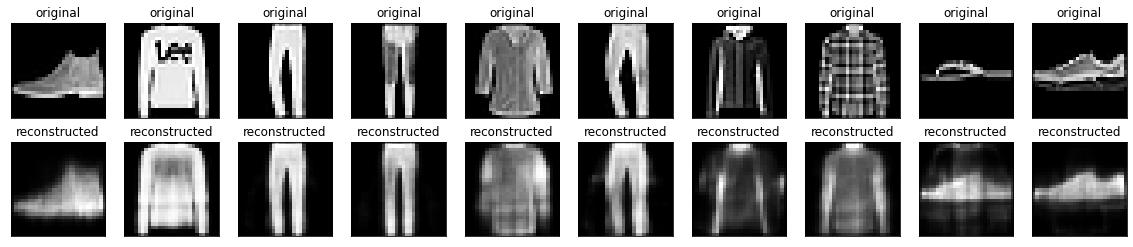

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Use Boostrapping to estimate latent distribution for each class



In [9]:
(train_images2, train_labels2), (test_images2, test_labels2) = fashion_mnist.load_data()


In [10]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [11]:
def fix_non_positive_definite_matrix(A,eps=0.01):
    logger = logging.getLogger('fix_non_positive_definite_matrix')
    e,v = tf.linalg.eigh(A)
    e_fix = e * tf.cast(tf.greater(e,0),dtype=tf.float32)+eps *tf.cast(tf.less_equal(e,0),dtype=tf.float32)
    A_fix = tf.matmul(v,tf.matmul(tf.linalg.diag(e_fix),tf.transpose(v)))
    A_norm = tf.norm(A)
    A_fix_norm = tf.norm(A_fix)
    corr_err = tf.math.round(1.0*tf.math.abs(A_norm-A_fix_norm)/A_norm,10)
    logger.info(f'Correction error : {corr_err}')
    logger.info(f'VV^T after fixing = {tf.linalg.diag_part(tf.matmul(v,tf.transpose(v)))}')
    return A_fix

In [12]:
def calc_z_likelihood(z,raxis = 0):
    logger = logging.getLogger('calc_z_likelihood')
    sample_mean = tf.reduce_max(input_tensor=z,axis=raxis)
    sample_cov = tfp.stats.covariance(x=z)
    sample_cov_fixed  = fix_non_positive_definite_matrix(sample_cov)
    
    e,v = tf.linalg.eigh(tensor=sample_cov_fixed)
    logger.info(f'Eigenvalues for sample covariance marix : shape =  {e.shape} , values = {e}')

    L = tf.linalg.cholesky(input=sample_cov_fixed)
    
    sample_var = tf.linalg.diag_part(input=sample_cov)+0.1
#     logger.debug(f'sample_mean = {sample_mean.shape}')
#     logger.debug(f'sample_cov = {sample_cov.shape}')
    logger.debug(f'sample_var = {sample_var}')
    mvn_diag = tfp.distributions.MultivariateNormalDiag(loc=sample_mean,scale_diag=sample_var)
    mvn_tri = tfp.distributions.MultivariateNormalTriL(loc=sample_mean,scale_tril=L)
    log_p_diag = tf.reduce_sum(mvn_diag.log_prob(z))
    log_p_tri = tf.reduce_sum(mvn_tri.log_prob(z))
    logger.debug(f' log_p_tri = {log_p_tri}')
    logger.debug(f' log_p_diag = {log_p_diag}')
    logger.debug(f'Ratio log_p_tri / log_p_diag = {np.round(log_p_tri/log_p_diag,3)}')
    

In [ ]:
unique_labels = np.unique(train_labels2)
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('Main')

auto_encoders = dict()
for label in unique_labels:
    train_idx = train_labels2==label
    test_idx = test_labels2 == label
    
    train_images_label = train_images2[train_idx,:,:]
    test_images_label = test_images2[test_idx,:,:]
#     print(class_names[label])
#     plt.imshow(train_images_label[0,:,:])
#     plt.show()
    logger.info(f'Training autoencoder for label {label} with name {class_names[label]}')
    auto_encoders[label] = autoencoder = Autoencoder(latent_dim)
    auto_encoders[label].compile(optimizer='adam', loss=losses.MeanSquaredError())
    auto_encoders[label].fit(train_images_label, train_images_label,
                epochs=10,
                shuffle=True,
                validation_data=(test_images_label, test_images_label))
    
    z = auto_encoders[label].encoder(test_images_label)
    if z.shape[0] >2:
        s = StandardScaler()
        z_scaled = s.fit(z)
        pca = PCA(n_components=2)
        z_pca = pca.fit_transform(z)
        z1 = z_pca[:,0]
        z2 = z_pca[:,1]
    elif z.shape[0] == 2:
        z1 = z[:,0].numpy()
        z2 = z[:,1].numpy()
    else:
        raise ValueError('Z shape must be >=2')
    plt.hist2d(z1, z2, bins=(50, 50), cmap=plt.cm.jet)
    plt.show()
    
    logger.info(f'Z shape of auto_encoder_{class_names[label]} = {z.shape}')
    try:
        calc_z_likelihood(z=z)
    except Exception as e:
        print(e)
        continue
    

INFO:Main:Training autoencoder for label 0 with name T-shirt/top


Epoch 1/10
188/188 [==============================] - 1s 2ms/step - loss: 14747.9959 - val_loss: 14871.4717
Epoch 2/10
188/188 [==============================] - 0s 967us/step - loss: 14770.7605 - val_loss: 14871.4688
Epoch 3/10
188/188 [==============================] - 0s 980us/step - loss: 14597.9967 - val_loss: 14871.0459
Epoch 4/10
188/188 [==============================] - 0s 990us/step - loss: 14685.5602 - val_loss: 14869.1250
Epoch 5/10
188/188 [==============================] - 0s 991us/step - loss: 14761.6670 - val_loss: 14864.4922
Epoch 6/10
188/188 [==============================] - 0s 999us/step - loss: 14602.7012 - val_loss: 14864.4932
Epoch 7/10
188/188 [==============================] - 0s 987us/step - loss: 14581.6974 - val_loss: 14864.4932
Epoch 8/10
188/188 [==============================] - 0s 976us/step - loss: 14689.9640 - val_loss: 14864.4922
Epoch 9/10
188/188 [==============================] - 0s 1ms/step - loss: 14834.2313 - val_loss: 14864.4863
Epoch 10/10
 6

In [ ]:
# measure of matrix diagonality
# https://math.stackexchange.com/a/1392524 

Handling the problem of "Cholesky decomposition was not successful"
https://www.tensorflow.org/probability/examples/TensorFlow_Probability_Case_Study_Covariance_Estimation#using_the_cholesky_decomposition_of_the_covariance_matrix

## Correcting  sample cov matrix to be positive definite 
1. https://math.stackexchange.com/a/54820
2. Algo 
    2.1 calculate eigenval and vec
    
    2.2 for the eigenval vector, calculate the norm of -ve values over all values and calculate error
    
    2.3 set all -ve values to eps > 0 (eps is small) 
    
    2.4 Generate using eigne value decomposition A_bar = V D V_T and compare A_bar with original A
    
    the idea to re-generate a close symmetric postive definite approximate covariance matrix
    